# Evaluating `_KerasSiameseNeuralNetwork`

Enable logging.

In [1]:
import logging


logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

Make sure that all annotated page and screen images can fit into the cache.

In [2]:
from video699.configuration import CONFIGURATION as configuration


configuration['ImageABC']['lru_cache_maxsize'] = '2000'
configuration['ScreenABC']['lru_cache_maxsize'] = '1000'

Conserve VRAM by instructing TensorFlow to allocate memory on demand.

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Perform leave-one-out cross-validation of the Siamese Neural Network model.

In [5]:
import numpy as np
from sklearn.model_selection import KFold
from video699.video.annotated import get_videos
from video699.event.siamese import _KerasSiameseNeuralNetwork


annotated_videos = np.array(sorted(get_videos().values(), key=lambda video: video.uri))
kfold = KFold(len(annotated_videos))
training_histories = dict()
for training_set, validation_set in kfold.split(annotated_videos):
    training_videos = set(annotated_videos[training_set])
    validation_video, = annotated_videos[validation_set] 
    model = _KerasSiameseNeuralNetwork(training_videos)
    training_histories[validation_video] = model.training_history

2019-01-02 11:50:12,431 : Extracting projection screen moments
2019-01-02 11:50:16,034 : Extracting document page moments
2019-01-02 11:52:58,617 : Done extracting statistical moments
2019-01-02 11:52:58,707 : Produced a dataset containing 27480 annotated image pairs
2019-01-02 11:52:58,717 : Produced a dataset containing 2049 annotated image pairs
2019-01-02 11:52:58,720 : Training a model for 25 epochs
2019-01-02 15:06:36,397 : Stored a model in /root/video699/video699/event/siamese/57b21806359e0a084c9ee5dcf4b5ffc5
2019-01-02 15:06:36,872 : Extracting projection screen moments
2019-01-02 15:06:39,371 : Extracting document page moments
2019-01-02 15:06:42,730 : Done extracting statistical moments
2019-01-02 15:06:42,855 : Produced a dataset containing 28351 annotated image pairs
2019-01-02 15:06:42,865 : Produced a dataset containing 1178 annotated image pairs
2019-01-02 15:06:42,867 : Training a model for 25 epochs
2019-01-02 18:19:50,330 : Stored a model in /root/video699/video699/e

Estimate and plot the mean of the training and the validation accuracy using [bootstrapping][].

 [bootstrapping]: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf (Bootstrap confidence intervals)

In [5]:
from video699.configuration import get_configuration


configuration = get_configuration()['KerasSiamesePageDetector']
num_training_epochs = configuration.getint('num_training_epochs')
alpha = 0.05
training_color = 'blue'
validation_color = 'red'
base_linewidth = 0.1
bound_linewidth = 1
mean_linewidth = 3
interval_alpha = 0.2

Plot the mean of the training and the validation accuracy.

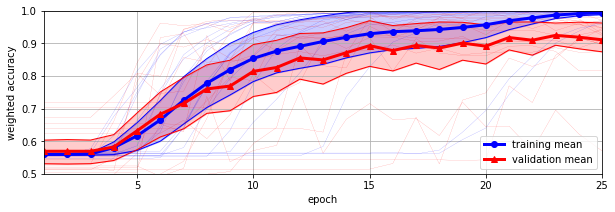

In [6]:
%matplotlib inline
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt


epochs = range(1, num_training_epochs + 1)

training_means = [
    bs.bootstrap(np.array([
        training_history['weighted_acc'][index] for training_history in training_histories.values()
    ]), stat_func=bs_stats.mean, alpha=alpha)
    for index in range(num_training_epochs)
]
training_means_pointwise = tuple(map(lambda x: x.value, training_means))
training_means_lower = tuple(map(lambda x: x.lower_bound, training_means))
training_means_upper = tuple(map(lambda x: x.upper_bound, training_means))

validation_means = [
    bs.bootstrap(np.array([
        training_history['val_weighted_acc'][index] for training_history in training_histories.values()
    ]), stat_func=bs_stats.mean, alpha=alpha)
    for index in range(num_training_epochs)
]
validation_means_pointwise = tuple(map(lambda x: x.value, validation_means))
validation_means_lower = tuple(map(lambda x: x.lower_bound, validation_means))
validation_means_upper = tuple(map(lambda x: x.upper_bound, validation_means))

plt.figure(1, figsize=(10, 3))

plt.plot(epochs, training_means_lower, color=training_color, linewidth=bound_linewidth)
plt.plot(epochs, training_means_upper, color=training_color, linewidth=bound_linewidth)
plt.fill_between(epochs, training_means_lower, training_means_upper, color=training_color, alpha=interval_alpha)

plt.plot(epochs, validation_means_lower, color=validation_color, linewidth=bound_linewidth)
plt.plot(epochs, validation_means_upper, color=validation_color, linewidth=bound_linewidth)
plt.fill_between(epochs, validation_means_lower, validation_means_upper, color=validation_color, alpha=interval_alpha)

for training_history in training_histories.values():
    plt.plot(epochs, training_history['weighted_acc'], color=training_color, linewidth=base_linewidth)
    plt.plot(epochs, training_history['val_weighted_acc'], color=validation_color, linewidth=base_linewidth)

plt.plot(epochs, training_means_pointwise, marker='o', color=training_color, linewidth=mean_linewidth, label='training mean')
plt.plot(epochs, validation_means_pointwise, marker='^', color=validation_color, linewidth=mean_linewidth, label='validation mean')

plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.xlim(1, num_training_epochs)
plt.ylabel('weighted accuracy')
plt.ylim(0.5, 1)
plt.grid()
plt.savefig('figures/siamese-21.pdf')
plt.show()

Show the outlier, and the best-performing validation video.

In [7]:
sorted_videos = sorted(get_videos().values(), key=lambda video: max(training_histories[video]['val_weighted_acc']))

PB069-D2-20140305.mp4,	validation weighted accuracy: 0.75 (epoch 11)


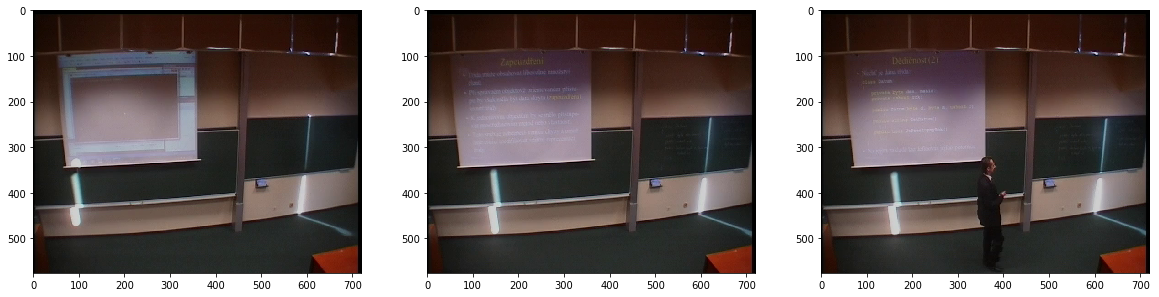

In [8]:
video = sorted_videos[0]
epoch, validation_accuracy = max(enumerate(training_histories[video]['val_weighted_acc']), key=lambda x: x[1])
print('{},\tvalidation weighted accuracy: {:.2f} (epoch {})'.format(video.filename, validation_accuracy, epoch))

plt.figure(figsize=(20, 12))
for index, frame in zip(range(3), video):
    plt.subplot(1, 3, index + 1).imshow(frame.image)
plt.savefig('figures/siamese-22.pdf')

PA152-D3-20110331.avi,	validation weighted accuracy: 1.00 (epoch 22)


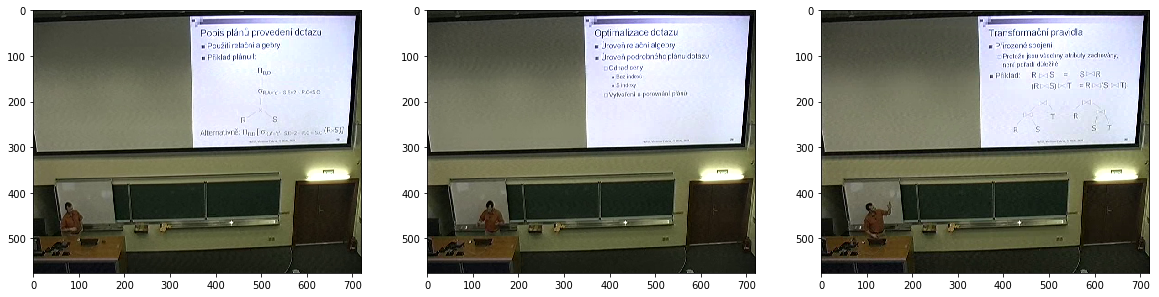

In [9]:
video = sorted_videos[-1]
epoch, validation_accuracy = max(enumerate(training_histories[video]['val_weighted_acc']), key=lambda x: x[1])
print('{},\tvalidation weighted accuracy: {:.2f} (epoch {})'.format(video.filename, validation_accuracy, epoch))

plt.figure(figsize=(20, 12))
for index, frame in zip(range(3), video):
    plt.subplot(1, 3, index + 1).imshow(frame.image)
plt.savefig('figures/siamese-23.pdf')